# News Category Classfier

## 1. 准备环境与导入库

In [ ]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import json
import math
import random
import re
from collections import Counter
from typing import List, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report

# 2. 设置随机种子 ———— 42 
# 保证可复现性
def set_seed(seed: int = 42) -> None:
    random.seed(seed)                          # Python 内置随机库
    torch.manual_seed(seed)                    # PyTorch CPU 随机种子
    torch.cuda.manual_seed_all(seed)           # PyTorch GPU (CUDA)

# 3. 选择计算设备 (Device Selection)
force_mps = True
if force_mps and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: mps (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device: cuda")
else:
    device = torch.device("cpu")
    print("Using device: cpu")

set_seed(42)

Using device: mps (Apple Silicon)


## 2. 读取数据与探索性分析 (EDA)
读取数据文件，查看数据基本信息、类别分布、文本长度统计，并展示部分样例。

样本总数: 209527

==================== 数据画像 ====================
缺失值统计:
headline             0
category             0
short_description    0
authors              0
dtype: int64

类别分布 (Top 5):
category
Politics & World Affairs    53567
Arts & Entertainment        44473
Lifestyle & Leisure         37611
Health & Wellness           24639
Society & Identity          18209
Name: count, dtype: int64

文本长度统计 (Headline & Description):
       headline_len  desc_len
count      209527.0  209527.0
mean           58.4     114.2
std            18.8      80.8
min             0.0       0.0
25%            46.0      59.0
50%            60.0     120.0
75%            71.0     134.0
max           320.0    1472.0


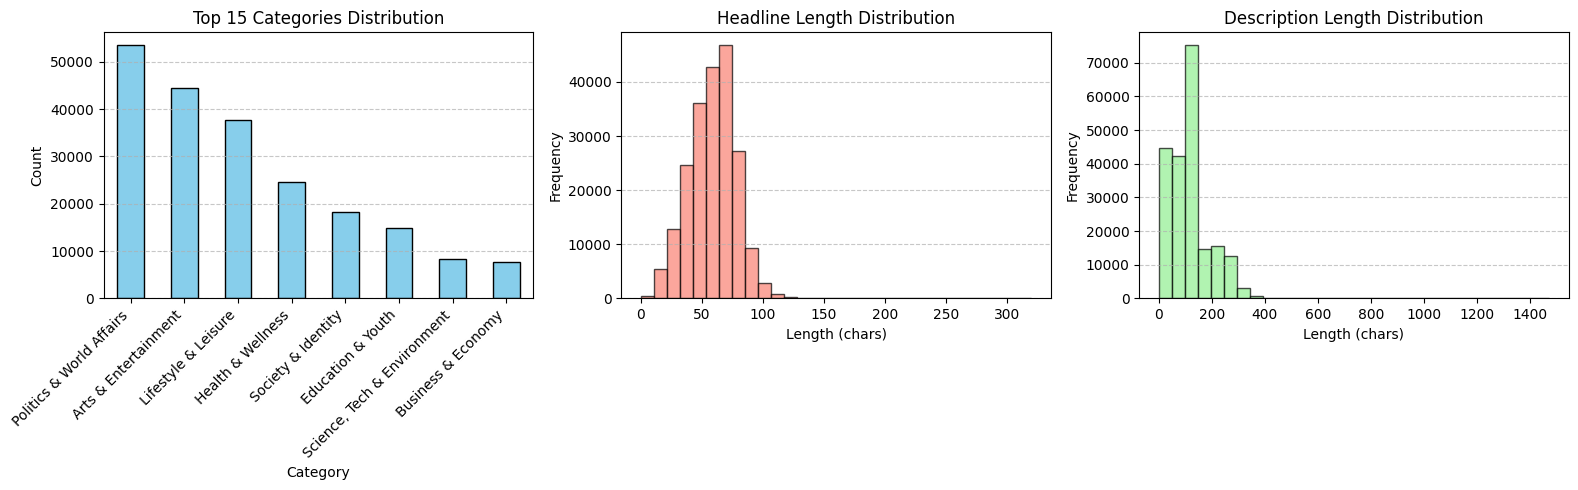


==================== 数据样例 ====================

[Index 204336] Category: Business & Economy
Headline: Jon Corzine, Ex-MF Global CEO, Stands By Previous Testimony
Description: The $200 million transfer from a customer fund account to JPMorgan was made to cover a $175 million overdraft in one of MF

[Index 202497] Category: Lifestyle & Leisure
Headline: Let Me Be Clear...
Description: No one walks down the aisle at their wedding hoping that they will one day be divorced. In other words, no one "wants" divorce.

[Index 91293] Category: Lifestyle & Leisure
Headline: This Elderly Couple Wore The Cutest 'His And Hers' Rival Baseball Jerseys
Description: A perfect match.


In [2]:
# 1. 读取数据文件
data_path = "../DATA/dataset.json"
with open(data_path, "r", encoding="utf-8") as f:
    records = json.load(f)

print(f"样本总数: {len(records)}")

# 2. 数据画像 (Data Profiling)
# 使用 Pandas 进行快速统计
df = pd.DataFrame(records)

print("\n" + "="*20 + " 数据画像 " + "="*20)
# 检查缺失值
print(f"缺失值统计:\n{df.isnull().sum()}")

# 类别分布
print("\n类别分布 (Top 5):")
category_counts = df['category'].value_counts()
print(category_counts.head(5))

# 文本长度统计
df['headline_len'] = df['headline'].fillna("").apply(len)
df['desc_len'] = df['short_description'].fillna("").apply(len)

print("\n文本长度统计 (Headline & Description):")
print(df[['headline_len', 'desc_len']].describe().round(1))

# --- 可视化展示 ---
plt.figure(figsize=(16, 5))

# 图1: 类别分布 (Top 15)
plt.subplot(1, 3, 1)
category_counts.head(15).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 15 Categories Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图2: Headline 长度分布
plt.subplot(1, 3, 2)
plt.hist(df['headline_len'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
plt.title("Headline Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 图3: Description 长度分布
plt.subplot(1, 3, 3)
plt.hist(df['desc_len'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title("Description Length Distribution")
plt.xlabel("Length (chars)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 3. 展示样例数据
print("\n" + "="*20 + " 数据样例 " + "="*20)
# 随机抽取 3 条展示
samples = df.sample(3)
for idx, row in samples.iterrows():
    print(f"\n[Index {idx}] Category: {row['category']}")
    print(f"Headline: {row['headline']}")
    print(f"Description: {row['short_description']}")

## 3. 第一、二个训练模型

### 1.数据处理与模型构建


In [3]:
# --- 自定义分词器 (Tokenizer) ---
# 作用：将文本字符串转换为数字 ID 序列。
class WhitespaceTokenizer:
    def __init__(self, max_vocab_size: int = 30000, min_freq: int = 2, max_length: int = 64):
        self.max_vocab_size = max_vocab_size  # 词表最大容量
        self.min_freq = min_freq              # 最小词频，低于此频率的词将被忽略
        self.max_length = max_length          # 序列最大长度，超过截断，不足补齐
        # 定义特殊 Token
        self.pad_token = "<pad>"  # 填充符，用于将不同长度的句子补齐到相同长度 (ID=0)
        self.unk_token = "<unk>"  # 未知词，用于表示词表中不存在的词 (ID=1)
        self.cls_token = "<cls>"  # 分类符，通常放在句子开头，用于汇聚整个句子的语义 (ID=2)
        # 初始化词表映射
        self.token_to_id = {self.pad_token: 0, self.unk_token: 1, self.cls_token: 2}
        self.id_to_token = {0: self.pad_token, 1: self.unk_token, 2: self.cls_token}

    # 简单的分词逻辑：转小写 -> 去首尾空格 -> 按空格切分
    # 改进：使用正则切分标点符号，避免 "apple," 和 "apple" 被视为不同词
    def tokenize(self, text: str) -> List[str]:
        text = text.lower().strip()
        # \w+ 匹配单词字符，[^\w\s] 匹配标点符号
        return re.findall(r"\w+|[^\w\s]", text)

    # 构建词表：统计所有文本中的词频，选取高频词加入词表
    def build_vocab(self, texts: List[str]) -> None:
        counter = Counter()
        for t in texts:
            counter.update(self.tokenize(t))
        # 选取最常见的词，过滤掉低频词
        most_common = [w for w, c in counter.most_common(self.max_vocab_size) if c >= self.min_freq]
        # 将这些词加入映射字典
        for idx, token in enumerate(most_common, start=len(self.token_to_id)):
            if token not in self.token_to_id:
                self.token_to_id[token] = idx
                self.id_to_token[idx] = token

    # 编码：将文本转换为 ID 序列和 Attention Mask
    def encode(self, text: str) -> Tuple[List[int], List[int]]:
        # 1. 添加 <cls> 并分词
        tokens = [self.cls_token] + self.tokenize(text)
        # 2. 截断：如果超过最大长度，切掉后面的
        tokens = tokens[: self.max_length]
        # 3. 查表转换：将词转为 ID，找不到的转为 <unk>
        ids = [self.token_to_id.get(tok, self.token_to_id[self.unk_token]) for tok in tokens]
        # 4. 填充：如果长度不足，用 <pad> 补齐
        pad_length = self.max_length - len(ids)
        if pad_length > 0:
            ids += [self.token_to_id[self.pad_token]] * pad_length
        # 5. 生成 Mask：1 表示有效内容，0 表示填充内容（模型不应关注填充部分）
        # Attention Mask 用于告诉 Self-Attention 机制哪些位置是真实的词，哪些只是填充的占位符
        attention_mask = [1 if i != self.token_to_id[self.pad_token] else 0 for i in ids]
        return ids, attention_mask


# --- 自定义数据集 (Dataset) ---
class NewsDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer: WhitespaceTokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        # 获取第 idx 条数据，并进行编码
        ids, mask = self.tokenizer.encode(self.texts[idx])
        # 返回 PyTorch 张量 (Tensor)
        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }


# --- 位置编码 (Positional Encoding) ---
# 我们需要通过位置编码将“位置信息”注入到输入向量中。
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        # 创建一个 max_len x d_model 的矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # 使用正弦和余弦函数生成位置信息
        # 这种编码方式可以让模型学习到相对位置关系
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        # register_buffer 告诉 PyTorch 这是一个状态，但不是需要更新的参数（梯度为不需要）
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 将位置编码加到输入的 Embedding 上
        # x.size(1) 是当前序列的实际长度
        return x + self.pe[:, : x.size(1)]


# --- 文本分类模型 (Classifier) ---
# 架构：Embedding -> PositionalEncoding -> TransformerEncoder -> Linear Classifier
class NewsClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_labels: int, d_model: int = 128, num_heads: int = 4, num_layers: int = 2, dim_feedforward: int = 256, dropout: float = 0.1):
        super().__init__()
        # 1. 词嵌入层：将整数 ID 映射为 d_model 维的稠密向量
        # padding_idx=0 表示 ID 为 0 的词向量始终为 0，不参与更新
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        # 2. 位置编码层：给词向量加上位置信息
        self.pos_encoder = PositionalEncoding(d_model)
        
        # 3. Transformer 编码器层定义
        # d_model: 输入向量维度
        # nhead: 多头注意力的头数
        # dim_feedforward: 前馈神经网络的隐藏层维度
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, # 输入格式为 (batch, seq, feature)
        )
        # 4. 堆叠多层 Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        
        # 5. 分类头：将 Transformer 的输出映射到类别数量
        self.classifier = nn.Linear(d_model, num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        # 生成 padding mask 
        padding_mask = attention_mask == 0
        
        # 1. 获取词向量并缩放
        x = self.embedding(input_ids) * math.sqrt(self.embedding.embedding_dim)
        # 2. 加上位置编码
        x = self.pos_encoder(x)
        # 3. 通过 Transformer 编码器
        # src_key_padding_mask 用于屏蔽掉 padding 部分，防止其影响注意力计算
        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)
        
        # 4. 获取句子表示
        # 取第一个 token (<cls>) 的输出作为整个句子的表示
        cls_repr = x[:, 0, :]
        
        # 5. 分类
        logits = self.classifier(self.dropout(cls_repr))
        return logits

### 2. 数据处理

In [4]:
# --- 数据准备函数 ---
def prepare_datasets(records, tokenizer: WhitespaceTokenizer, text_key: str = "headline", split_ratios: Tuple[float, float, float] = (0.7, 0.15, 0.15)):
    """
    准备数据集
    :param records: 原始数据列表
    :param tokenizer: 分词器实例
    :param text_key: 使用哪个字段作为输入文本 ("headline" 或 "short_description")
    :param split_ratios: (Train, Val, Meta) 的比例
    """
    df = pd.DataFrame(records)
    
    # 确保字段存在，如果不存在则填充空字符串
    if text_key not in df.columns:
        print(f"Warning: Key '{text_key}' not found in dataset. Using empty strings.")
        texts = [""] * len(df)
    else:
        texts = df[text_key].fillna("").tolist()
        
    labels_raw = df["category"].tolist()

    # 1. 构建标签映射 (Label Mapping)
    unique_labels = sorted(set(labels_raw))
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for label, i in label2id.items()}
    labels = [label2id[l] for l in labels_raw]

    # 2. 构建词表 (针对当前指定的文本字段)
    tokenizer.build_vocab(texts)

    # 3. 创建数据集对象
    dataset = NewsDataset(texts, labels, tokenizer)
    
    # 4. 划分训练集、验证集和 Meta 训练集
    total_size = len(dataset)
    train_size = int(split_ratios[0] * total_size)
    val_size = int(split_ratios[1] * total_size)
    meta_size = total_size - train_size - val_size
    
    # 使用固定种子进行划分，确保不同模型训练时使用的是同一份数据划分
    train_ds, val_ds, meta_ds = random_split(
        dataset, 
        [train_size, val_size, meta_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset prepared for key='{text_key}': Train={len(train_ds)}, Val={len(val_ds)}, Meta={len(meta_ds)}, Vocab={len(tokenizer.token_to_id)}")
    return train_ds, val_ds, meta_ds, label2id, id2label


# --- 数据批处理函数 ---
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])
    return input_ids, attention_mask, labels

### 3.训练与评估循环


==================== 开始并行训练双流模型 ====================

==================== 开始训练模型: headline ====================

==================== 开始训练模型: short_description ====================
Dataset prepared for key='headline': Train=146668, Val=31429, Meta=31430, Vocab=30003
Class weights calculated (min=0.49, max=3.42)
Dataset prepared for key='short_description': Train=146668, Val=31429, Meta=31430, Vocab=30003
Class weights calculated (min=0.49, max=3.42)
[headline] Epoch 1/100 | Step 50/4584 | loss=2.1670
[short_description] Epoch 1/100 | Step 50/4584 | loss=2.1668
[short_description] Epoch 1/100 | Step 100/4584 | loss=2.0851
[headline] Epoch 1/100 | Step 100/4584 | loss=2.1408
[headline] Epoch 1/100 | Step 150/4584 | loss=1.8598
[short_description] Epoch 1/100 | Step 150/4584 | loss=2.0816
[short_description] Epoch 1/100 | Step 200/4584 | loss=1.8797
[headline] Epoch 1/100 | Step 200/4584 | loss=2.1075
[headline] Epoch 1/100 | Step 250/4584 | loss=2.0004
[short_description] Epoch 1/100 |

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/transformer.py:467: UserWarning: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:15.)
  ) and not torch._nested_tensor_from_mask_left_aligned(


                             precision    recall  f1-score   support

       Arts & Entertainment       0.58      0.45      0.51      6642
         Business & Economy       0.39      0.30      0.34      1219
          Education & Youth       0.48      0.58      0.53      2197
          Health & Wellness       0.48      0.57      0.52      3661
        Lifestyle & Leisure       0.50      0.54      0.52      5689
   Politics & World Affairs       0.72      0.58      0.64      8074
Science, Tech & Environment       0.22      0.41      0.28      1266
         Society & Identity       0.37      0.45      0.40      2681

                   accuracy                           0.52     31429
                  macro avg       0.47      0.49      0.47     31429
               weighted avg       0.54      0.52      0.52     31429

[headline] Epoch 1/100: train_loss=1.6941, val_acc=0.5158
                             precision    recall  f1-score   support

       Arts & Entertainment       0.50   

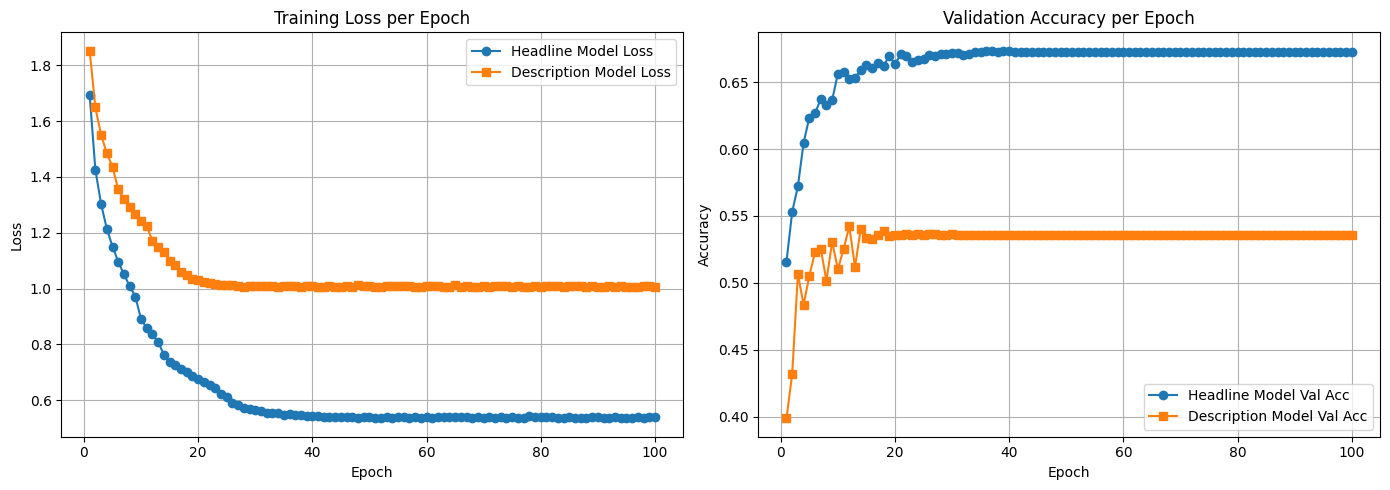

In [ ]:
# --- 核心训练逻辑封装 ---
import time

# 训练函数
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch: int, num_epochs: int, prefix: str = "", log_every: int = 2000):
    # 1. 将模型设置为训练模式（启用 Dropout 和 BatchNorm 的更新）
    model.train()
    total_loss = 0.0
    # 2. 遍历 DataLoader 中的每一个 Batch
    # enumerate(..., start=1) 让 step 从 1 开始计数
    for step, (input_ids, attention_mask, labels) in enumerate(dataloader, start=1):
        # 3. 将数据移动到计算设备 (MPS)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 4. 清空上一步的梯度（PyTorch 默认会累加梯度，所以每次都要清零）
        optimizer.zero_grad()
        # 5. 前向传播：将数据喂给模型，得到预测结果 (logits)
        logits = model(input_ids, attention_mask)
        # 6. 计算损失：比较预测结果 logits 和真实标签 labels
        loss = criterion(logits, labels)
        # 7. 反向传播：计算梯度
        loss.backward()
        # 8. 参数更新：根据梯度调整模型参数
        optimizer.step()

        # 累加损失（loss.item() 是平均 loss，乘以 batch_size 得到该 batch 的总 loss）
        total_loss += loss.item() * input_ids.size(0)
        # 9. 每隔 log_every 步打印一次日志
        if step % log_every == 0:
            print(f"[{prefix}] Epoch {epoch}/{num_epochs} | Step {step}/{len(dataloader)} | loss={loss.item():.4f}")
    # 返回整个 Epoch 的平均 Loss
    return total_loss / len(dataloader.dataset)

# 评估函数
def evaluate_detailed(model, dataloader, device, id2label):
    # 1. 将模型设置为评估模式（关闭 Dropout，固定 BatchNorm）
    model.eval()
    all_preds = []
    all_labels = []
    
    # 2. 禁用梯度计算（节省显存和计算资源，因为评估不需要反向传播）
    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            logits = model(input_ids, attention_mask)
            # 3. 获取预测类别：在最后一个维度上取最大值的索引
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # 4. 生成详细的分类报告（包含精确率、召回率、F1值）
    target_names = [id2label[i] for i in range(len(id2label))]
    # zero_division=0 避免某些类别未出现时的警告
    report = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)
    print(report)
    
    # 5. 计算并返回总体准确率 (Accuracy)
    correct = sum([1 for p, l in zip(all_preds, all_labels) if p == l])
    return correct / len(all_labels)

def run_training_pipeline(text_key: str, save_name: str, num_epochs: int = 2):
    print(f"\n{'='*20} 开始训练模型: {text_key} {'='*20}")
    start_time = time.time()
    
    # 1. 初始化分词器
    tokenizer = WhitespaceTokenizer(max_vocab_size=30000, min_freq=2, max_length=64)
    
    # 2. 准备数据 (Train / Val / Meta)
    train_ds, val_ds, meta_ds, label2id, id2label = prepare_datasets(records, tokenizer, text_key=text_key)
    
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    # 由于 train_ds 是 Subset，我们需要访问其 underlying dataset
    all_labels = [train_ds.dataset.labels[i] for i in train_ds.indices]
    label_counts = Counter(all_labels)
    # 权重 = 总样本数 / (类别数 * 类别样本数)
    total_samples = len(all_labels)
    num_classes = len(label2id)
    weights = [total_samples / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)]
    class_weights = torch.FloatTensor(weights).to(device)
    print(f"Class weights calculated (min={min(weights):.2f}, max={max(weights):.2f})")

    # 3. 初始化模型
    model = NewsClassifier(
        vocab_size=len(tokenizer.token_to_id),
        num_labels=len(label2id),
        d_model=128,
        num_heads=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 4. 训练循环
    best_val_acc = 0.0
    # --- 可视化数据记录 ---
    history = {"train_loss": [], "val_acc": []}
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs, prefix=text_key)
        
        print(f"--- Validation Report Epoch {epoch} ---")
        val_acc = evaluate_detailed(model, val_loader, device, id2label)
        print(f"[{text_key}] Epoch {epoch}/{num_epochs}: train_loss={train_loss:.4f}, val_acc={val_acc:.4f}")

        # 记录训练数据
        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        # 更新学习率
        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                "model_state_dict": model.state_dict(),
                "label2id": label2id,
                "id2label": id2label,
                "vocab": tokenizer.token_to_id,
                "config": {
                    "d_model": model.embedding.embedding_dim,
                    "num_heads": model.transformer_encoder.layers[0].self_attn.num_heads,
                    "num_layers": len(model.transformer_encoder.layers),
                    "dim_feedforward": model.transformer_encoder.layers[0].linear1.out_features,
                    "max_length": tokenizer.max_length,
                    "text_key": text_key
                },
            }, save_name)
            print(f"已保存最优模型 ({text_key}): {save_name}")
            
    print(f"[{text_key}] 训练结束，最佳验证准确率: {best_val_acc:.4f}")
    end_time = time.time()
    print(f"[{text_key}] 训练耗时: {end_time - start_time:.2f}s")
    return best_val_acc, history

# --- 并行训练 ---
import concurrent.futures
import time

print(f"\n{'='*20} 开始并行训练双流模型 {'='*20}")
start_time = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    
    epochs = 100

    future_headline = executor.submit(run_training_pipeline, text_key="headline", save_name="../Results/first/best_model_headline.pt", num_epochs=epochs)
    future_desc = executor.submit(run_training_pipeline, text_key="short_description", save_name="../Results/first/best_model_description.pt", num_epochs=epochs)

    acc_headline, hist_headline = future_headline.result()
    acc_desc, hist_desc = future_desc.result()

end_time = time.time()
print(f"\n并行训练结束，总耗时: {end_time - start_time:.2f}s")
print(f"Headline Acc: {acc_headline:.4f}")
print(f"Description Acc: {acc_desc:.4f}")

# --- 训练过程可视化 ---
plt.figure(figsize=(14, 5))

# 1. 绘制损失曲线 (Loss Curve)
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), hist_headline["train_loss"], label="Headline Model Loss", marker='o')
plt.plot(range(1, epochs + 1), hist_desc["train_loss"], label="Description Model Loss", marker='s')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 2. 绘制准确率曲线 (Accuracy Curve)
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), hist_headline["val_acc"], label="Headline Model Val Acc", marker='o')
plt.plot(range(1, epochs + 1), hist_desc["val_acc"], label="Description Model Val Acc", marker='s')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 4.第三个模型

### 模型定义

In [ ]:
# --- 权重模型定义 ---
import torch.nn.functional as F

# 使用一个简单的多层感知机 (MLP) 学习如何组合两个基础模型的输出。
# 基础模型 (Base Models): Headline Model, Description Model
# 元模型 (Meta Model): 接收基础模型的预测概率，输出最终的预测结果
# 输入: [Headline_Probs (N), Description_Probs (N)] -> 维度 2N
# 输出: Final_Logits (N)
class MetaClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # 线性层 1
            nn.ReLU(),                        # 激活函数
            nn.Dropout(0.2),                  # 防止过拟合
            nn.Linear(hidden_dim, output_dim) # 线性层 2 -> 输出最终类别 Logits
        )

    def forward(self, x):
        return self.net(x)

def load_base_model(path, device):
    """辅助函数：加载基础模型用于特征提取"""
    # 加载 checkpoint
    checkpoint = torch.load(path, map_location=device)
    vocab = checkpoint["vocab"]
    cfg = checkpoint.get("config", {})
    
    # 重建分词器
    tokenizer = WhitespaceTokenizer(
        max_vocab_size=len(vocab),
        min_freq=1,
        max_length=cfg.get("max_length", 64),
    )
    tokenizer.token_to_id = vocab
    tokenizer.id_to_token = {v: k for k, v in vocab.items()}

    # 重建模型结构
    model = NewsClassifier(
        vocab_size=len(tokenizer.token_to_id),
        num_labels=len(checkpoint["label2id"]),
        d_model=cfg.get("d_model", 128),
        num_heads=cfg.get("num_heads", 4),
        num_layers=cfg.get("num_layers", 2),
        dim_feedforward=cfg.get("dim_feedforward", 256),
        dropout=0.1,
    ).to(device)
    # 加载模型参数
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval() # 设置为评估模式
    return model, tokenizer, checkpoint["label2id"]

def generate_meta_dataset(records, val_indices, model_h, tok_h, model_d, tok_d, label2id, device):
    """
    生成元数据 (Meta-Dataset)
    遍历验证集，分别通过两个基础模型，收集它们的预测概率作为 Meta Model 的输入特征。
    """
    X = []
    y = []
    
    print(f"Generating meta-features from {len(val_indices)} validation samples...")
    
    with torch.no_grad():
        for idx in val_indices:
            item = records[idx]
            label_str = item["category"]
            if label_str not in label2id: continue
            target = label2id[label_str]
            
            # 1. Headline Model Prediction (标题模型预测)
            h_ids, h_mask = tok_h.encode(item.get("headline", ""))
            h_in = torch.tensor([h_ids]).to(device)
            h_msk = torch.tensor([h_mask]).to(device)
            # 获取 Softmax 后的概率分布
            probs_h = F.softmax(model_h(h_in, h_msk), dim=1).cpu().tolist()[0]
            
            # 2. Description Model Prediction (摘要模型预测)
            d_ids, d_mask = tok_d.encode(item.get("short_description", ""))
            d_in = torch.tensor([d_ids]).to(device)
            d_msk = torch.tensor([d_mask]).to(device)
            # 获取 Softmax 后的概率分布
            probs_d = F.softmax(model_d(d_in, d_msk), dim=1).cpu().tolist()[0]
            
            # 3. Concatenate Features (特征拼接)
            # 特征向量 = [标题预测概率分布, 摘要预测概率分布]
            # 例如：如果有 5 个类别，probs_h 长度为 5，probs_d 长度为 5，拼接后长度为 10
            meta_features = probs_h + probs_d 
            
            X.append(meta_features)
            y.append(target)
            
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

### 训练模型

Meta-training set size: 31430
Loading base models for meta-training...
Generating meta-features from 31430 validation samples...

==================== 开始训练 Meta Model (权重融合) ====================
Meta Epoch 2/20: loss=0.9203, acc=0.7099
Meta Epoch 4/20: loss=0.9140, acc=0.7111
Meta Epoch 6/20: loss=0.9080, acc=0.7115
Meta Epoch 8/20: loss=0.9027, acc=0.7124
Meta Epoch 10/20: loss=0.8942, acc=0.7128
Meta Epoch 12/20: loss=0.8885, acc=0.7138
Meta Epoch 14/20: loss=0.8843, acc=0.7137
Meta Epoch 16/20: loss=0.8821, acc=0.7149
Meta Epoch 18/20: loss=0.8785, acc=0.7149
Meta Epoch 20/20: loss=0.8761, acc=0.7163
已保存 Meta Model: best_meta_model.pt


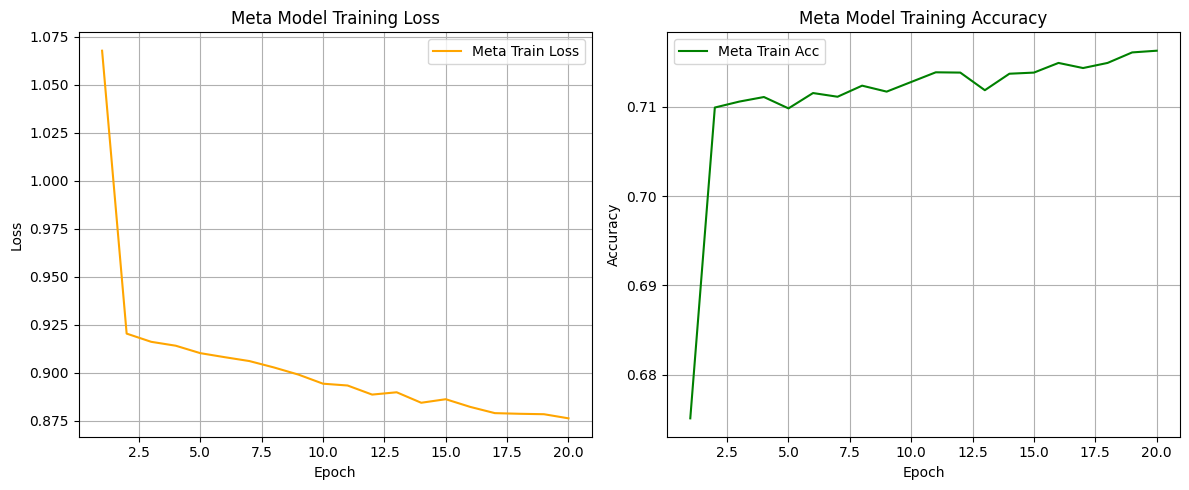

In [ ]:
# --- 训练 Meta Model ---
import time

# 1. 重新获取数据集划分 (获取 Meta 训练集)
# 必须与 prepare_datasets 中的划分逻辑完全一致
full_ds_size = len(records)
train_size = int(0.7 * full_ds_size)
val_size = int(0.15 * full_ds_size)
meta_size = full_ds_size - train_size - val_size

# 使用相同的 seed=42 复现划分
_, _, meta_subset = random_split(
    range(full_ds_size), 
    [train_size, val_size, meta_size], 
    generator=torch.Generator().manual_seed(42)
)
meta_indices = meta_subset.indices

print(f"Meta-training set size: {len(meta_indices)}")

# 2. 加载已训练的基础模型
print("Loading base models for meta-training...")
model_h, tok_h, label2id_h = load_base_model("../Results/first/best_model_headline.pt", device)
model_d, tok_d, label2id_d = load_base_model("../Results/first/best_model_description.pt", device)

# 确保标签映射一致
assert label2id_h == label2id_d, "Label mappings do not match!"
num_classes = len(label2id_h)

# 3. 生成 Meta-Dataset
X_meta, y_meta = generate_meta_dataset(records, meta_indices, model_h, tok_h, model_d, tok_d, label2id_h, device)

# 4. 划分 Meta-Train / Meta-Val
meta_dataset = torch.utils.data.TensorDataset(X_meta, y_meta)
meta_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)

# 5. 初始化 Meta Model
# 输入维度 = 类别数 * 2 (两个模型的概率分布拼接)
meta_model = MetaClassifier(input_dim=num_classes * 2, hidden_dim=64, output_dim=num_classes).to(device)
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=0.001)
meta_criterion = nn.CrossEntropyLoss()

# 6. 训练循环
print(f"\n{'='*20} 开始训练 Meta Model (权重融合) {'='*20}")
start_time = time.time()

num_meta_epochs = 20 # Meta Model 很小，收敛快

meta_history = {"loss": [], "acc": []} # 记录 Meta Model 训练历史

for epoch in range(1, num_meta_epochs + 1):
    meta_model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in meta_loader:
        features = features.to(device)
        labels = labels.to(device)
        
        meta_optimizer.zero_grad()
        logits = meta_model(features)
        loss = meta_criterion(logits, labels)
        loss.backward()
        meta_optimizer.step()
        
        total_loss += loss.item() * features.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    avg_loss = total_loss / total
    acc = correct / total
    
    # 记录数据
    meta_history["loss"].append(avg_loss)
    meta_history["acc"].append(acc)
    
    if epoch % 2 == 0:
        print(f"Meta Epoch {epoch}/{num_meta_epochs}: loss={avg_loss:.4f}, acc={acc:.4f}")

# 7. 保存 Meta Model
torch.save(meta_model.state_dict(), "../Results/first/best_meta_model.pt")
print("已保存 Meta Model: ../Results/first/best_meta_model.pt")
end_time = time.time()
print(f"Meta Model 训练耗时: {end_time - start_time:.2f}s")

# --- Meta Model 训练可视化 ---
plt.figure(figsize=(12, 5))

# 绘制 Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_meta_epochs + 1), meta_history["loss"], label="Meta Train Loss", color='orange')
plt.title("Meta Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# 绘制 Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_meta_epochs + 1), meta_history["acc"], label="Meta Train Acc", color='green')
plt.title("Meta Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 5.模型使用

In [10]:
import os
import torch.nn.functional as F
import numpy as np

class SingleModelPredictor:
    """单个模型的预测器封装"""
    def __init__(self, checkpoint_path, device):
        self.device = device
        self.model, self.tokenizer, self.id2label, self.config = self._load_model(checkpoint_path)
        
    def _load_model(self, checkpoint_path):
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Model file not found: {checkpoint_path}")
            
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        vocab = checkpoint["vocab"]
        label2id = checkpoint["label2id"]
        id2label = checkpoint["id2label"]
        cfg = checkpoint.get("config", {})

        tokenizer = WhitespaceTokenizer(
            max_vocab_size=len(vocab),
            min_freq=1,
            max_length=cfg.get("max_length", 64),
        )
        tokenizer.token_to_id = vocab
        tokenizer.id_to_token = {v: k for k, v in vocab.items()}

        model = NewsClassifier(
            vocab_size=len(tokenizer.token_to_id),
            num_labels=len(label2id),
            d_model=cfg.get("d_model", 128),
            num_heads=cfg.get("num_heads", 4),
            num_layers=cfg.get("num_layers", 2),
            dim_feedforward=cfg.get("dim_feedforward", 256),
            dropout=0.1,
        ).to(self.device)
        
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        return model, tokenizer, id2label, cfg

    def get_probs(self, text: str):
        """返回预测概率分布 (Softmax output)"""
        ids, attn = self.tokenizer.encode(text)
        input_ids = torch.tensor([ids], dtype=torch.long).to(self.device)
        attention_mask = torch.tensor([attn], dtype=torch.long).to(self.device)
        
        with torch.no_grad():
            logits = self.model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1) # 转换为概率
        return probs


class EnsemblePredictor:
    """集成预测器：结合标题模型和摘要模型的结果"""
    def __init__(self, headline_model_path="Results/best_model_headline.pt", desc_model_path="Results/best_model_description.pt", meta_model_path="Results/best_meta_model.pt", device=device):
        self.device = device
        self.headline_predictor = None
        self.desc_predictor = None
        self.meta_model = None
        
        # 1. 加载基础模型
        if os.path.exists(headline_model_path):
            print(f"Loading Headline Model from {headline_model_path}...")
            self.headline_predictor = SingleModelPredictor(headline_model_path, device)
        
        if os.path.exists(desc_model_path):
            print(f"Loading Description Model from {desc_model_path}...")
            self.desc_predictor = SingleModelPredictor(desc_model_path, device)
            
        # 2. 加载 Meta Model (权重模型)
        if os.path.exists(meta_model_path) and self.headline_predictor and self.desc_predictor:
            print(f"Loading Meta Model from {meta_model_path}...")
            num_classes = len(self.headline_predictor.id2label)
            # Meta Model 输入维度是两个基础模型类别数之和
            self.meta_model = MetaClassifier(input_dim=num_classes * 2, hidden_dim=64, output_dim=num_classes).to(device)
            self.meta_model.load_state_dict(torch.load(meta_model_path, map_location=device))
            self.meta_model.eval()
        else:
            print("Warning: Meta Model not loaded (or base models missing). Will use simple averaging if needed.")

        # 设置 id2label (假设两个模型标签一致)
        if self.headline_predictor:
            self.id2label = self.headline_predictor.id2label
        elif self.desc_predictor:
            self.id2label = self.desc_predictor.id2label
        else:
            raise RuntimeError("No models loaded! Please train models first.")

    def predict(self, headline: str = "", description: str = ""):
        """
        综合预测函数 (使用 Meta Model 进行融合)
        """
        probs_h = None
        probs_d = None
        
        # 1. 获取基础模型预测
        if headline and self.headline_predictor:
            probs_h = self.headline_predictor.get_probs(headline)
            
        if description and self.desc_predictor:
            probs_d = self.desc_predictor.get_probs(description)
            
        # 2. 综合决策逻辑
        if probs_h is not None and probs_d is not None:
            # Case 3: 两者都有 -> 使用 Meta Model 融合
            if self.meta_model:
                # 拼接特征: [probs_h, probs_d]
                meta_input = torch.cat([probs_h, probs_d], dim=1)
                with torch.no_grad():
                    final_logits = self.meta_model(meta_input)
                    final_probs = F.softmax(final_logits, dim=1)
                # print("Mode: Ensemble (Meta Model)")
            else:
                # Fallback: 简单平均 (如果没有训练 Meta Model)
                final_probs = 0.6 * probs_h + 0.4 * probs_d
                # print("Mode: Ensemble (Simple Average)")
                
        elif probs_h is not None:
            # Case 1: 只有标题 (例如摘要缺失)
            final_probs = probs_h
            # print("Mode: Headline Only")
        elif probs_d is not None:
            # Case 2: 只有摘要 (例如标题缺失)
            final_probs = probs_d
            # print("Mode: Description Only")
        else:
            return "Unknown"
            
        # 获取最大概率对应的类别
        pred_idx = torch.argmax(final_probs, dim=1).item()
        return self.id2label[pred_idx]

# --- 示例运行 ---
try:
    ensemble = EnsemblePredictor()
    
    test_cases = [
        {
            "headline": "NASA announces new moon mission", 
            "desc": "The space agency revealed plans for the Artemis program to return humans to the lunar surface."
        },
        {
            "headline": "Stocks surge as tech leads the rally", 
            "desc": "" # 缺失摘要
        },
        {
            "headline": "", # 缺失标题
            "desc": "A new study published in Nature shows that daily meditation can reduce stress levels significantly."
        }
    ]
    
    print("\n--- Inference Results ---")
    for case in test_cases:
        h = case["headline"]
        d = case["desc"]
        pred = ensemble.predict(headline=h, description=d)
        print(f"Headline: {h[:30]}... | Desc: {d[:30]}... -> Prediction: {pred}")
        
except Exception as e:
    print(f"Error during inference: {e}")
    import traceback
    traceback.print_exc()
    print("请确保已运行上方的训练单元并生成了 .pt 模型文件。")

Loading Headline Model from Results/best_model_headline.pt...
Loading Description Model from Results/best_model_description.pt...
Loading Meta Model from Results/best_meta_model.pt...

--- Inference Results ---
Headline: NASA announces new moon missio... | Desc: The space agency revealed plan... -> Prediction: Science, Tech & Environment
Headline: Stocks surge as tech leads the... | Desc: ... -> Prediction: Business & Economy
Headline: ... | Desc: A new study published in Natur... -> Prediction: Health & Wellness
